In [1]:
%load_ext autoreload
%autoreload 2


In [192]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch
import tqdm
import umap

import celltrip


# Load Data and Policy

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/DrugSeries/expression.h5ad', backed=True)

# Model location and name
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251013', 800  # 32 dim

# Load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adata.obs['Training'] = mask

# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')

# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

# Run Untreated and Knockdown

In [4]:
# Parameters
print(adata.obs['treatment'].unique().to_numpy())
series = ['Untreated', 'DMSO', 'Tram']
timesteps = ['3hr', '6hr', '12hr', '24hr', '48hr']

['DMSO_48hr' 'Tram_24hr' 'DMSO_12hr' 'Tram_3hr' 'Tram_6hr' 'Tram_12hr'
 'Tram_48hr' 'Untreated_48hr' 'DMSO_3hr' 'DMSO_24hr' 'DMSO_6hr']


In [147]:
# Get untreated
# untreated_target = 'Untreated_48hr'
untreated_target = 'DMSO_48hr'
# untreated_target = 'Tram_3hr'
untreated_idx = adata.obs_names[np.argwhere(adata.obs['treatment'] == untreated_target).flatten()]
untreated_data = np.array(adata[untreated_idx].X.todense())
untreated_pre, = preprocessing.transform([untreated_data])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(untreated_pre), compute_rewards=False, dim=32).eval(time_scale=5).to('cuda')

# Compute steady state
ret = celltrip.train.simulate_until_completion(
    env, policy, skip_states=100, store_states='cpu', progress_bar=True)
untreated_steady_state_full = ret[-1][-1]
untreated_steady_state = untreated_steady_state_full[..., :env.dim]
with torch.no_grad(): untreated_gex = policy.pinning[0](untreated_steady_state.to('cuda')).detach().cpu().numpy()
untreated_gex, = preprocessing.inverse_transform(untreated_gex, subset_modality=0)

6400it [00:50, 126.63it/s]


In [148]:
# Compute knockdown
skip_states = 16
sim_time = 128.
gene_names = ['MAP2K1', 'MAP2K2']
knocked_target = 'Tram_48hr'

# Get feature targets
gene_idx = adata.var_names[adata.var['gene_name'].isin(gene_names)].to_numpy().astype(int)
knocked_data = np.array(adata[np.argwhere(adata.obs['treatment'] == knocked_target).flatten()].X.todense())
feature_targets = knocked_data[:, gene_idx].mean(axis=0)

# Perform simulation
env.reset().set_max_time(sim_time)
env.set_state(untreated_steady_state_full.to('cuda'))
ret = celltrip.train.simulate_until_completion(
    env, policy,
    env_hooks=[
        # celltrip.utility.hooks.clamp_input_features_hook(
        #     gene_idx, preprocessing, feature_targets=0., modality_idx=0,
        #     device='cuda'),
        celltrip.utility.hooks.clamp_inverted_features_hook(
            gene_idx, preprocessing, feature_targets=feature_targets, modality_idx=0),
    ],
    action_hooks=[
        celltrip.utility.hooks.move_toward_targets_hook(
            gene_idx, feature_targets=feature_targets, pinning=policy.pinning[0],
            preprocessing=preprocessing, modality_idx=0,
            factor=1, device=env.device)
    ],
    skip_states=skip_states, store_states='cpu', progress_bar=True)
knocked_timeseries = ret[-1][..., :env.dim]
with torch.no_grad(): knocked_gex = policy.pinning[0](knocked_timeseries.to('cuda')).detach().cpu().numpy()
knocked_gex, = preprocessing.inverse_transform(knocked_gex, subset_modality=0)


1281it [00:29, 43.98it/s]


## Visualize

In [163]:
# Calculate pdelta results
eps = 30  # Minimum var difference for which we should compute correlation
all_treatments = [f'Tram_{t}' for t in timesteps]  # [1:]
pdelta_results = pd.DataFrame(index=all_treatments, columns=skip_states*np.arange(knocked_timeseries.shape[0]), dtype=float)
pert_diffs = []
for treatment in pdelta_results.index:
    # Get actual perturbation delta
    pert_idx = adata.obs_names[np.argwhere(adata.obs['treatment'] == treatment).flatten()]
    pert_data = np.array(adata[pert_idx].X.todense())
    pert_diff = pert_data.mean(axis=-2) - untreated_data.mean(axis=-2)
    pert_diffs.append(pert_diff)

    # Get predicted perturbation delta
    pred_diff = knocked_gex.mean(axis=-2) - np.expand_dims(untreated_gex, axis=0).mean(axis=-2)
    # pred_diff = knocked_gex.mean(axis=-2) - knocked_gex[[5]].mean(axis=-2)
    # pred_diff_nan_mask = np.abs(pred_diff).mean(axis=-1) < eps
    pred_diff_nan_mask = pred_diff.var(axis=-1) < eps

    # Calculate pearson delta for prediction
    pdelta = np.corrcoef(np.expand_dims(pert_diff, axis=0), pred_diff)[0, 1:]  # Not optimal
    # pdelta = -np.square(np.expand_dims(pert_diff, axis=0) - pred_diff).mean(axis=-1)  # MSE
    pdelta_results.loc[treatment] = pdelta
    # pdelta_results.loc[treatment, pred_diff_nan_mask] = np.nan  # Mask out unreliably low perturbations

    # Calculate pearson delta for actual
    pdelta = np.corrcoef(np.expand_dims(pert_diff, axis=0), pred_diff)

# Crop first and last timestep - same as untreated and uneven step, respectively
pdelta_results = pdelta_results.iloc[:, 1:-1]

# Get pearson delta for actual
pert_diffs = np.stack(pert_diffs, axis=0)
pdelta = np.corrcoef(pert_diffs)
pdelta_actual = pd.DataFrame(pdelta, index=all_treatments, columns=all_treatments, dtype=float)

# Normalize
# pdelta_results_norm = (pdelta_results - pdelta_results.to_numpy().mean(keepdims=True, axis=1)) / pdelta_results.to_numpy().std(keepdims=True, axis=1)
# pdelta_actual_norm = (pdelta_actual - pdelta_actual.to_numpy().mean(keepdims=True, axis=1)) / pdelta_actual.to_numpy().nanstd(keepdims=True, axis=1)
pdelta_results_norm = (pdelta_results - np.nanmean(pdelta_results.to_numpy(), keepdims=True, axis=1)) / np.nanstd(pdelta_results.to_numpy(), keepdims=True, axis=1)
pdelta_actual_norm = (pdelta_actual - np.nanmean(pdelta_actual.to_numpy(), keepdims=True, axis=1)) / np.nanstd(pdelta_actual.to_numpy(), keepdims=True, axis=1)
# pdelta_results_norm = (pdelta_results - pdelta_results.to_numpy().min(keepdims=True, axis=1)) / (pdelta_results.to_numpy().max(keepdims=True, axis=1) - pdelta_results.to_numpy().min(keepdims=True, axis=1))
# pdelta_actual_norm = (pdelta_actual - pdelta_actual.to_numpy().min(keepdims=True, axis=1)) / (pdelta_results.to_numpy().max(keepdims=True, axis=1) - pdelta_results.to_numpy().min(keepdims=True, axis=1))

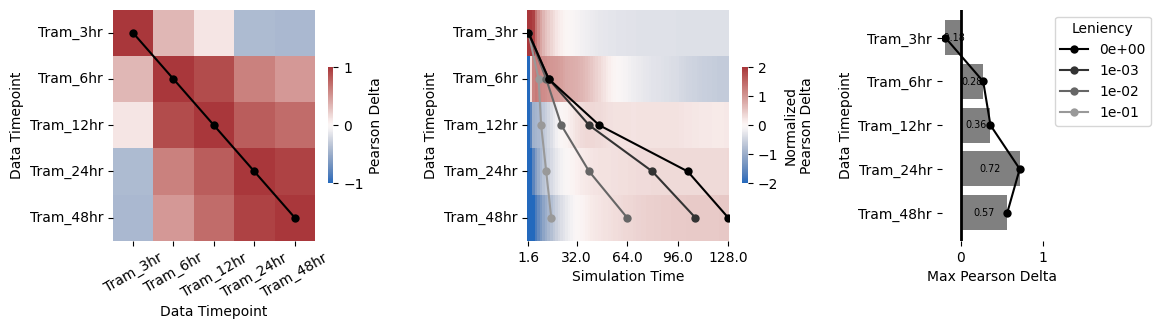

In [238]:
# Create figure
widths = [5, 5, 2]
line_kwargs = dict(marker='o', markersize=6, markeredgecolor='none')
fig, axs = plt.subplots(1, 3, figsize=(sum(widths), 3), width_ratios=widths)
fig.subplots_adjust(wspace=.8)

# Annotate max
num_lines = 4
eps_list = np.concat([np.logspace(-1, -3, num_lines-1, base=10), [0]])
white_list = np.linspace(.6, 0., num_lines)
def get_peak(df, kernel_size=None, eps=1e-2):
    # Default params
    if kernel_size is None: kernel_size = np.ceil((10/sim_time)*df.shape[1]).astype(int)
    # Moving window
    smoothed = np.stack([
        np.convolve(df.to_numpy()[i], np.ones(kernel_size) / kernel_size, mode='full')
        for i in range(df.shape[0])], axis=0)
    return (smoothed >= smoothed.max(keepdims=True, axis=1) - eps).argmax(axis=1)
    # return smoothed.argmax(axis=1)
    # Weighted mean
    # data = df.to_numpy()
    # data = (data - data.min(keepdims=True, axis=1)) / data.std(keepdims=True, axis=1)  # / (data.max(keepdims=True, axis=1) - data.min(keepdims=True, axis=1))
    # data = np.exp(data)  # Scaling exp
    # data = data / data.sum(keepdims=True, axis=1)
    # return (data * np.expand_dims(np.arange(data.shape[1]), axis=0)).sum(axis=1)
    # First to max-eps
    # return (df.to_numpy() >= df.to_numpy().max(keepdims=True, axis=1) - eps).argmax(axis=1)
    # Max
    # return df.to_numpy().argmax(axis=1)

# Reference pdelta heatmap
ax = axs[0]
sns.heatmap(
    pdelta_actual,
    cmap='vlag', vmin=-1, vmax=1,
    cbar_kws={
        'shrink': .5, 'ticks': np.arange(-1, 1.01, 1.),
        'label': 'Pearson Delta'}, ax=ax)
ax.set(xlabel='Data Timepoint', ylabel='Data Timepoint')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# Annotate max
ax.plot(
    get_peak(pdelta_actual, eps=0) + .5,
    np.arange(pdelta_actual.shape[0]) + .5,
    color='black', **line_kwargs)

# Actual pdelta heatmap
ax = axs[1]
df_use = pdelta_results_norm
# df_use = pdelta_results
sns.heatmap(
    df_use,
    cmap='vlag',
    vmin=-2, vmax=2,
    cbar_kws={
        'shrink': .5,
        'ticks': np.arange(-2, 2.01, 1.),
        'label': 'Normalized\nPearson Delta'}, ax=ax)
ax.set(xlabel='Simulation Time', ylabel='Data Timepoint')
xtick_step = df_use.shape[1] / 4
xticks = np.array([1] + np.arange(
    xtick_step, xtick_step*(1+df_use.shape[1]//xtick_step), xtick_step).tolist()) - .5
xticklabels = skip_states * env.delta * (xticks + .5)
xticklabels = [f'{l:.1f}' for l in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=0)
# Annotate max
for eps, white in zip(eps_list, white_list):
    ax.plot(
        get_peak(pdelta_results, eps=eps) + .5,
        np.arange(pdelta_results.shape[0]) + .5,
        color=3*[white], **line_kwargs)

# Peak performance
ax = axs[2]
pdelta_results_max = pdelta_results.max(axis=1).reset_index()
pdelta_results_max.columns = ['Data Timepoint', 'Max Pearson Delta']
bar = sns.barplot(pdelta_results_max, x='Max Pearson Delta', y='Data Timepoint', orient='y', color='gray', ax=ax)
sns.lineplot(pdelta_results_max, x='Max Pearson Delta', y='Data Timepoint', orient='y', color='black', **line_kwargs, ax=ax)
ax.bar_label(bar.containers[0], fmt='{:0.2f}', label_type='center', fontsize='x-small')
# ax.set(ylabel=None, yticklabels=[], yticks=[])
ax.set_xlim(right=1.)
# ax.tick_params(axis='x', which='major', length=0)
ax.axvline(x=0, color='black', lw=2)
sns.despine(left=True, bottom=True)

# Make legend
ax.legend(handles=[
    mpl.lines.Line2D([], [], color=3*[white], **line_kwargs, label=f'{eps:.0e}')
    for eps, white in zip(eps_list, white_list)][::-1],
    loc='upper left', bbox_to_anchor=(1.05, 1.), title='Leniency')

fig.savefig('../plots/drugseries/Timed_Pearson_Delta.pdf')

# Interpolate

In [369]:
# Generate fake data for viz
# TODO: Replace with real start, end, pseudocells, and interp
start_cells = np.random.rand(100, 2) + np.array([[-2.5, 2.5]])
mid_cells = np.random.rand(100, 2) + np.array([[-1, 1.5]])
end_cells = np.random.rand(100, 2) + np.array([[0, .5]])
num_timesteps = 21
interp_cells = np.linspace(0, 1., num_timesteps).reshape((-1, 1, 1))
interp_cells = (
    (1-interp_cells) * np.repeat(np.expand_dims(start_cells, axis=0), num_timesteps, axis=0)
    + interp_cells * np.repeat(np.expand_dims(end_cells, axis=0), num_timesteps, axis=0))

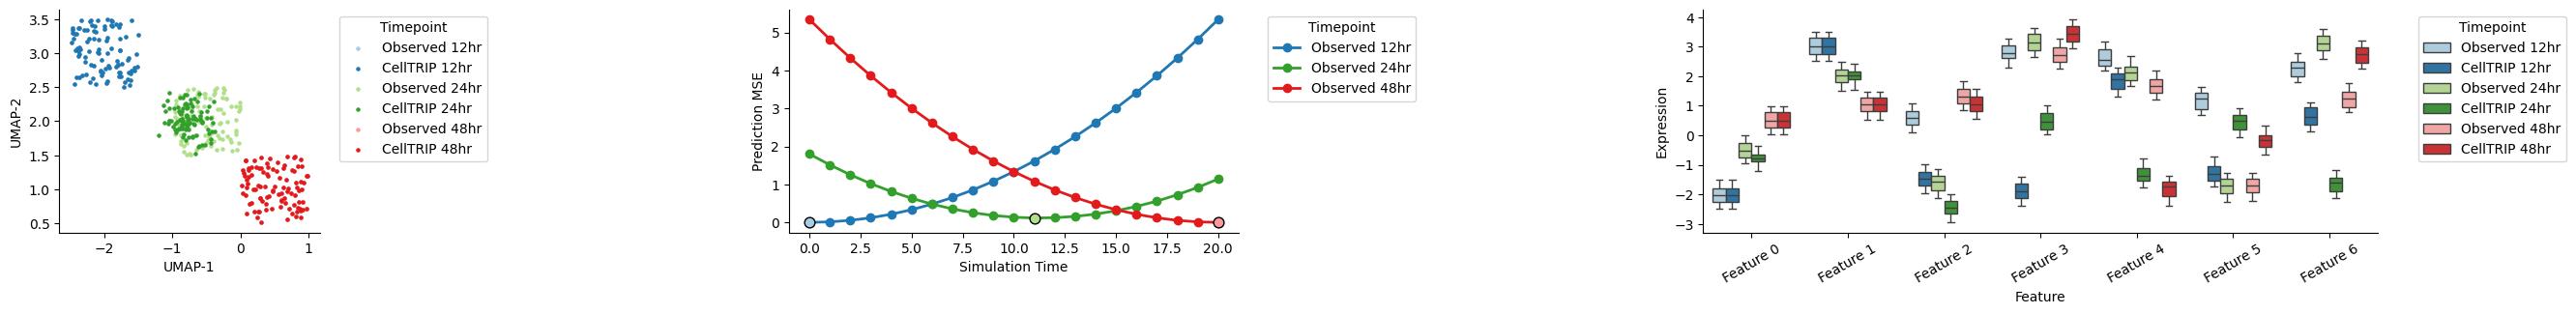

In [383]:
# Generate figure
widths = [6, 10, 15]
fig, axs = plt.subplots(1, 3, figsize=(sum(widths), 3), width_ratios=widths)
fig.subplots_adjust(wspace=1.)
# Result tuples
point_tuples = [
    ('Observed 12hr', start_cells),
    ('Observed 24hr', mid_cells),
    ('Observed 48hr', end_cells)]
celltrip_tuples = [
    ('CellTRIP 12hr', interp_cells[0]),
    ('CellTRIP 24hr', interp_cells[10]),
    ('CellTRIP 48hr', interp_cells[-1]),
]
# Combine tuples
all_tuples = point_tuples + celltrip_tuples
all_tuples = list(all_tuples[::3]) + list(all_tuples[1::3]) + list(all_tuples[2::3])
all_colors = list(colors[1::2]) + list(colors[::2])
# Paired colors
all_colors = sns.color_palette('Paired', 6)
colors = list(all_colors[1::2]) + list(all_colors[::2])

# UMAP
ax = axs[0]
for (name, points), color in zip(all_tuples, all_colors):
    ax.scatter(*points.T, s=5., color=color, label=name)
ax.set_aspect('equal')
sns.despine(ax=ax)
ax.set(xlabel='UMAP-1', ylabel='UMAP-2')
ax.legend(title='Timepoint', loc='upper left', bbox_to_anchor=(1.05, 1.))

# Distance by timepoint
ax = axs[1]
simulation_time = np.arange(interp_cells.shape[0])
for i, (name, points) in enumerate(point_tuples):
    mse = np.square(interp_cells - np.expand_dims(points, axis=0)).mean(axis=(-2, -1))
    ax.plot(simulation_time, mse, color=colors[i], lw=2, marker='o', markersize=6, label=name)
    if name == 'Observed 12hr':
        ax.scatter(simulation_time[[0]], mse[[0]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
    elif name == 'Observed 24hr':
        min_idx = mse.argmin()
        ax.scatter(simulation_time[[min_idx]], mse[[min_idx]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
    elif name == 'Observed 48hr':
        ax.scatter(simulation_time[[-1]], mse[[-1]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
sns.despine(ax=ax)
ax.set(xlabel='Simulation Time', ylabel='Prediction MSE')
ax.legend(title='Timepoint', loc='upper left', bbox_to_anchor=(1.05, 1.))

# Sample gene distances
ax = axs[2]
interp_distribution = []
for name, points in all_tuples:
    df = pd.DataFrame(points, columns=[f'Feature {i}' for i in range(points.shape[1])])
    for i in range(2, 7): df[f'Feature {i}'] = 3*2*(np.random.rand()-.5) + np.random.rand(df.shape[0])  # Add more fake points
    df['Timepoint'] = name
    interp_distribution.append(df)
interp_distribution = (
    pd.concat(interp_distribution, axis=0)
    .melt(id_vars='Timepoint', var_name='Feature', value_name='Expression'))
box = sns.boxplot(
    interp_distribution, x='Feature', y='Expression', hue='Timepoint',
    hue_order=list(map(lambda a: a[0], all_tuples)), palette=all_colors, ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(ax=ax)
sns.move_legend(box, loc='upper left', bbox_to_anchor=(1.05, 1.))

fig.savefig('../plots/drugseries/Interpolation_Performance.pdf')
